# 

In [1]:
pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
import csv
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader, Dataset, TensorDataset
import math
import logging
from datetime import datetime

import gzip
from scipy.stats import pearsonr
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


2024-03-31 12:45:22.081277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 12:45:22.081375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 12:45:22.220760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def df_clean(df):
    df_l = df.values.tolist()
    df_new = []
    c=0
    for i in df_l:
        # print(i)
        c=0
        for j in range(0,len(i)):

            if('main-news' in str(i[j]) or 'main-forum' in str(i[j])):
                # print(i)
                c=1
                continue
        if(c==0):
            if (pd.isnull(i[0]) or pd.isnull(i[1]) or pd.isnull(i[2])):
                continue
            df_new.append(i)
    df_new = pd.DataFrame(df_new, columns = ['score', 'sentence1', 'sentence2'])
    # df_new.to_csv('df_new.csv',index=False)
    return df_new

In [4]:
df_train = df_clean(pd.read_csv('/kaggle/input/nlp-task1-dataset/train.csv', delimiter='\t'))  #training dataset
df_val = df_clean(pd.read_csv('/kaggle/input/nlp-task1-dataset/dev.csv', delimiter='\t'))      #validation dataset

# df_train.to_csv('train_clean.csv',index=False)
df_train_l = df_train.values.tolist()
df_train

,score,sentence1,sentence2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...
5694,0.00,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia
5695,0.00,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...
5696,0.00,President heading to Bahrain,President Xi: China to continue help to fight ...
5697,0.00,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders


In [5]:
score_train = df_train['score'].tolist()
sentence_train = df_train[['sentence1', 'sentence2']].values.tolist()


score_val = df_val['score'].tolist()
sentence_val = df_val[['sentence1', 'sentence2']].values.tolist()

print(len(score_train), len(sentence_train))
print(len(score_val), len(sentence_val))
print(sentence_train[0])

5699 5699
1462 1462
['A plane is taking off.', 'An air plane is taking off.']


In [7]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

def preprocess_data(sentences, scores):
  encoded_inputs = []
  for sent1, sent2 in sentences:
    s = sent1 + sent2
    encoded_dict = tokenizer(s, max_length=60, padding='max_length', truncation=True, return_tensors='pt')
    encoded_inputs.append(encoded_dict)
  return encoded_inputs, torch.tensor(scores, dtype=torch.float32)

train_inputs, train_scores = preprocess_data(sentence_train, score_train)
val_inputs, val_scores = preprocess_data(sentence_val, score_val)



In [8]:
print(train_inputs[0])
print(train_scores[0])

{'input_ids': tensor([[ 101, 1037, 4946, 2003, 2635, 2125, 1012, 2019, 2250, 4946, 2003, 2635,
         2125, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
tensor(5.)


Device available: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_34/931098526.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(score, dtype=torch.float))


Epoch 1/10, Train Loss: 1.1808, Validation Loss: 0.6490, Pearson Correlation: 0.8499
Epoch 2/10, Train Loss: 0.5062, Validation Loss: 0.6208, Pearson Correlation: 0.8548
Epoch 3/10, Train Loss: 0.3010, Validation Loss: 0.6413, Pearson Correlation: 0.8525
Epoch 4/10, Train Loss: 0.2023, Validation Loss: 0.6321, Pearson Correlation: 0.8501
Epoch 5/10, Train Loss: 0.1465, Validation Loss: 0.6004, Pearson Correlation: 0.8573
Epoch 6/10, Train Loss: 0.1166, Validation Loss: 0.6414, Pearson Correlation: 0.8592
Epoch 7/10, Train Loss: 0.1057, Validation Loss: 0.5947, Pearson Correlation: 0.8599
Epoch 8/10, Train Loss: 0.1006, Validation Loss: 0.5915, Pearson Correlation: 0.8612
Epoch 9/10, Train Loss: 0.0875, Validation Loss: 0.5840, Pearson Correlation: 0.8623
Epoch 10/10, Train Loss: 0.0766, Validation Loss: 0.5788, Pearson Correlation: 0.8641


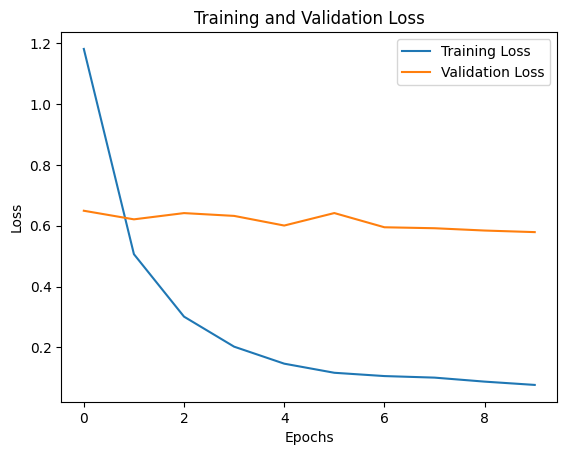

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available:", device)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

batch_size = 8
learning_rate = 2e-5
num_epochs = 10

def tokenize_data(sentences, scores):
    input_ids = []
    attention_masks = []
    labels = []

    for sentence_pair, score in zip(sentences, scores):
        input_ids.append(sentence_pair['input_ids'].flatten())
        attention_masks.append(sentence_pair['attention_mask'].flatten())
        labels.append(torch.tensor(score, dtype=torch.float))

    input_ids = torch.stack(input_ids).to(device)
    attention_masks = torch.stack(attention_masks).to(device)
    labels = torch.stack(labels).to(device)

    return TensorDataset(input_ids, attention_masks, labels)


train_dataset = tokenize_data(train_inputs, train_scores)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = tokenize_data(val_inputs, val_scores)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

 

train_losses = []
val_losses = []
pearson_corrs = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_mask, targets = batch
        input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits.mean(dim=1)
        loss = criterion(logits, targets)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * input_ids.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, targets_batch = batch
            input_ids, attention_mask, targets_batch = input_ids.to(device), attention_mask.to(device), targets_batch.to(device)
#             targets_batch = targets_batch.view(-1, 1)  
            targets.extend(targets_batch.cpu().numpy())

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.logits.squeeze(-1).cpu().numpy())
#             logits = np.array([(pred[0]+pred[1])/2 for pred in outputs.logits.squeeze(-1)]).reshape(-1)
            logits = outputs.logits
            logits = logits.mean(dim=1)
            loss = criterion(logits, targets_batch)
            running_val_loss += loss.item() * input_ids.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)


#     print(predictions)
#     print(targets)
    predictions = np.array([(pred[0]+pred[1])/2 for pred in predictions]).reshape(-1)
    targets = np.array(targets).reshape(-1)

    pearson_corr = np.corrcoef(predictions, targets)[0, 1]
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Pearson Correlation: {pearson_corr:.4f}")


plt.plot(train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training  Loss')
plt.show()


plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation  Loss')
plt.show()



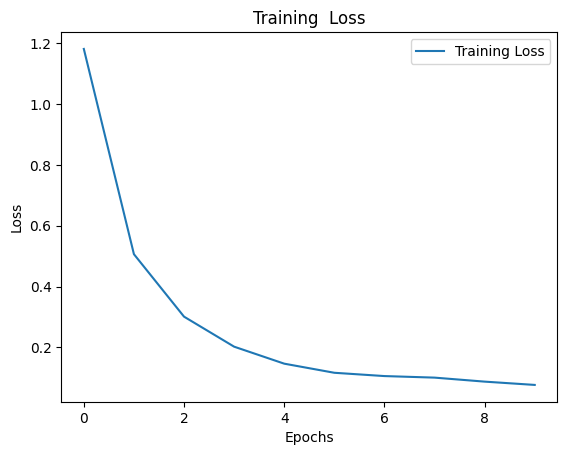

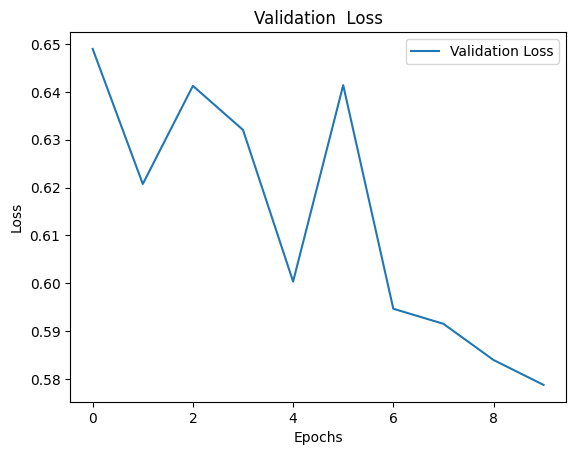

In [12]:
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training  Loss')
plt.show()


plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation  Loss')
plt.show()

In [13]:
import pickle

with open('bert_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [14]:
with open('bert_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [16]:
def df_clean_test(df):
    df_l = df.values.tolist()
    df_new = []
    c=0
    for i in df_l:
        # print(i)
        c=0
        for j in range(0,len(i)):

            if('main-news' in str(i[j]) or 'main-forum' in str(i[j])):
                # print(i)
                c=1
                continue
        if(c==0):
            if (pd.isnull(i[0]) or pd.isnull(i[1]) or pd.isnull(i[2])):
                continue
            df_new.append(i)
    df_new = pd.DataFrame(df_new, columns = ['id','sentence1', 'sentence2'])
    # df_new.to_csv('df_new.csv',index=False)
    return df_new

In [ ]:
df_score = pd.read_csv('test_score.csv')
test_score = df_score[['score']].values.tolist()

In [28]:
df_test = df_clean_test(pd.read_csv('/kaggle/input/nlp-task1-dataset/sample_demo.csv', delimiter='\t'))      #validation dataset

test_sentence = df_test[['sentence1', 'sentence2']].values.tolist()

test_sentence, test_score = preprocess_data(test_sentence, test_score)
test_dataset = tokenize_data(test_sentence, test_score)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = loaded_model
running_val_loss = 0.0
predictions = []
targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, targets_batch = batch
        input_ids, attention_mask, targets_batch = input_ids.to(device), attention_mask.to(device), targets_batch.to(device)
#             targets_batch = targets_batch.view(-1, 1)  
        targets.extend(targets_batch.cpu().numpy())

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.logits.squeeze(-1).cpu().numpy())
#             logits = np.array([(pred[0]+pred[1])/2 for pred in outputs.logits.squeeze(-1)]).reshape(-1)
        logits = outputs.logits
        logits = logits.mean(dim=1)
        loss = criterion(logits, targets_batch)
        running_val_loss += loss.item() * input_ids.size(0)

epoch_val_loss = running_val_loss / len(val_dataset)
val_losses.append(epoch_val_loss)

#     print(predictions)
#     print(targets)
predictions = np.array([(pred[0]+pred[1])/2 for pred in predictions]).reshape(-1)
targets = np.array(targets).reshape(-1)

pearson_corr = np.corrcoef(predictions, targets)[0, 1]
print(f"Test Loss: {epoch_val_loss:.4f}, Pearson Correlation: {pearson_corr:.4f}")

Test Loss: 0.0101, Pearson Correlation: 0.9929


/tmp/ipykernel_34/931098526.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(score, dtype=torch.float))
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
